# Tech challenge - Grupo 9 - É chikungunya?

## Sobre


### Dicionario de dados das colunas utilizadas

[Link detalhado](./dicionario_dados_colunas_utilizadas.md)


### Variáveis:

- df_original: valor do dataframe sem modificação
- df: valor do dataframe modificado ao longo dos blocos
- cols_sintomas: nomes de colunas relacionadas a sintomas
- cols_comorbidades: nomes de colunas relacionadas a sintomas 
- cols_exames: nomes de colunas relacionadas a exame
- col_target: nome da coluna target
- colunas_selecionada: soma de todas as colunas

### Links Úteis

- [Informações sobre a de dados](https://dadosabertos.saude.gov.br/dataset/arboviroses-febre-de-chikungunya)
- [Dicionário de dados](./dic_dados_chikungunya.pdf)
- [Base de dados 2025](./dados/CHIKBR25.csv)


## Requisitos

In [67]:
! pip install -r requirements.txt

## Importações e configurações

In [68]:
import pandas as pd
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [69]:
df_original = pd.read_csv("./dados/CHIKBR25.csv", low_memory=False)
df_original.head()

,TP_NOT,ID_AGRAVO,DT_NOTIFIC,SEM_NOT,NU_ANO,SG_UF_NOT,ID_MUNICIP,ID_REGIONA,ID_UNIDADE,DT_SIN_PRI,SEM_PRI,ANO_NASC,NU_IDADE_N,CS_SEXO,CS_GESTANT,CS_RACA,CS_ESCOL_N,SG_UF,ID_MN_RESI,ID_RG_RESI,ID_PAIS,DT_INVEST,ID_OCUPA_N,FEBRE,MIALGIA,CEFALEIA,EXANTEMA,VOMITO,NAUSEA,DOR_COSTAS,CONJUNTVIT,ARTRITE,ARTRALGIA,PETEQUIA_N,LEUCOPENIA,LACO,DOR_RETRO,DIABETES,HEMATOLOG,HEPATOPAT,RENAL,HIPERTENSA,ACIDO_PEPT,AUTO_IMUNE,DT_CHIK_S1,DT_CHIK_S2,DT_PRNT,RES_CHIKS1,RES_CHIKS2,RESUL_PRNT,DT_SORO,RESUL_SORO,DT_NS1,RESUL_NS1,DT_VIRAL,RESUL_VI_N,DT_PCR,RESUL_PCR_,SOROTIPO,HISTOPA_N,IMUNOH_N,HOSPITALIZ,DT_INTERNA,UF,MUNICIPIO,TPAUTOCTO,COUFINF,COPAISINF,COMUNINF,CLASSI_FIN,CRITERIO,DOENCA_TRA,CLINC_CHIK,EVOLUCAO,DT_OBITO,DT_ENCERRA,ALRM_HIPOT,ALRM_PLAQ,ALRM_VOM,ALRM_SANG,ALRM_HEMAT,ALRM_ABDOM,ALRM_LETAR,ALRM_HEPAT,ALRM_LIQ,DT_ALRM,GRAV_PULSO,GRAV_CONV,GRAV_ENCH,GRAV_INSUF,GRAV_TAQUI,GRAV_EXTRE,GRAV_HIPOT,GRAV_HEMAT,GRAV_MELEN,GRAV_METRO,GRAV_SANG,GRAV_AST,GRAV_MIOC,GRAV_CONSC,GRAV_ORGAO,DT_GRAV,MANI_HEMOR,EPISTAXE,GENGIVO,METRO,PETEQUIAS,HEMATURA,SANGRAM,LACO_N,PLASMATICO,EVIDENCIA,PLAQ_MENOR,CON_FHD,COMPLICA,NU_LOTE_I,TP_SISTEMA,NDUPLIC_N,DT_DIGITA,CS_FLXRET,FLXRECEBI,MIGRADO_W
0,2,A920,2024-12-30,202501,2024,32,320060,32001.00,2449218.00,2024-12-30,202501,1989.00,4035,F,5.00,1,6.00,32,320060.00,32001.00,1,2024-12-30,10001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.00,NaN,4.00,NaN,4.00,NaN,4.00,NaN,NaN,NaN,2.00,NaN,NaN,NaN,1.00,NaN,NaN,NaN,5.00,1.00,NaN,NaN,9.00,NaN,2025-01-17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2024-12-30,NaN,NaN,NaN
1,2,A920,2024-12-30,202501,2024,32,320405,32003.00,2484536.00,2024-12-29,202501,1980.00,4044,M,5.00,4,9.00,32,320405.00,32003.00,1,2024-12-30,10001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2024-12-30,1.00,NaN,NaN,NaN,2.00,NaN,NaN,NaN,1.00,NaN,NaN,NaN,13.00,1.00,NaN,NaN,1.00,NaN,2025-01-17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2024-12-30,NaN,NaN,NaN
2,2,A920,2024-12-30,202501,2024,32,320130,32002.00,2494450.00,2024-12-29,202501,1996.00,4028,M,6.00,4,9.00,32,320130.00,32002.00,1,2024-02-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.00,NaN,NaN,NaN,2.00,NaN,NaN,NaN,1.00,NaN,NaN,NaN,5.00,1.00,NaN,NaN,9.00,NaN,2025-02-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2024-12-30,NaN,NaN,NaN
3,2,A920,2024-12-30,202501,2024,32,320130,32002.00,2494450.00,2024-12-29,202501,1979.00,4045,F,5.00,1,9.00,32,320130.00,32002.00,1,2024-02-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.00,NaN,NaN,NaN,2.00,NaN,NaN,NaN,1.00,NaN,NaN,NaN,5.00,1.00,NaN,NaN,9.00,NaN,2025-02-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2024-12-30,NaN,NaN,NaN
4,2,A920,2024-12-30,202501,2024,32,320130,32002.00,2494450.00,2024-12-29,202501,2008.00,4016,F,5.00,4,9.00,32,320130.00,32002.00,1,2024-02-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.00,NaN,NaN,NaN,2.00,NaN,NaN,NaN,1.00,NaN,NaN,NaN,5.00,1.00,NaN,NaN,9.00,NaN,2025-02-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2024-12-30,NaN,NaN,NaN

## Análise Exploratória de Dados (EDA)

In [70]:
# Quantidade de linhas e colunas
df_original.shape

(248541, 122)

In [71]:
df_teste = df_original.copy()

null_ratio = df_teste.isnull().mean()
null_threshold = 0.99

# Remover colunas com mais de 70% de valores nulos
df_teste = df_teste.loc[:, df_teste.isnull().mean() < null_threshold]

df_teste.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 248541 entries, 0 to 248540
Data columns (total 68 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   TP_NOT      248541 non-null  int64  
 1   ID_AGRAVO   248541 non-null  object 
 2   DT_NOTIFIC  248541 non-null  object 
 3   SEM_NOT     248541 non-null  int64  
 4   NU_ANO      248541 non-null  int64  
 5   SG_UF_NOT   248541 non-null  int64  
 6   ID_MUNICIP  248541 non-null  int64  
 7   ID_REGIONA  241408 non-null  float64
 8   ID_UNIDADE  248462 non-null  float64
 9   DT_SIN_PRI  248541 non-null  object 
 10  SEM_PRI     248541 non-null  int64  
 11  ANO_NASC    247825 non-null  float64
 12  NU_IDADE_N  248541 non-null  int64  
 13  CS_SEXO     248541 non-null  object 
 14  CS_GESTANT  248513 non-null  float64
 15  CS_RACA     248541 non-null  int64  
 16  CS_ESCOL_N  206447 non-null  float64
 17  SG_UF       248541 non-null  int64  
 18  ID_MN_RESI  248539 non-null  float64
 19  ID

In [72]:
import numpy as np

df_teste_corr = df_teste.select_dtypes(include=[np.number]).corr()
df_teste_corr["CLASSI_FIN"].sort_values(ascending=False)

CLASSI_FIN    1.00
MUNICIPIO     0.15
UF            0.14
CRITERIO      0.12
ID_MN_RESI    0.11
ID_MUNICIP    0.11
SG_UF         0.11
SG_UF_NOT     0.11
RESUL_PCR_    0.04
RESUL_VI_N    0.04
NU_IDADE_N    0.04
ID_UNIDADE    0.04
CS_RACA       0.03
VOMITO        0.03
RESUL_PRNT    0.03
CEFALEIA      0.02
CLINC_CHIK    0.02
HOSPITALIZ    0.02
RES_CHIKS2    0.01
LEUCOPENIA    0.01
NU_ANO        0.00
COUFINF       0.00
HEPATOPAT     0.00
COMUNINF      0.00
DOR_RETRO    -0.00
RENAL        -0.00
HEMATOLOG    -0.00
COPAISINF    -0.00
ACIDO_PEPT   -0.00
AUTO_IMUNE   -0.00
CS_GESTANT   -0.01
LACO         -0.01
NAUSEA       -0.01
CONJUNTVIT   -0.03
DIABETES     -0.04
FEBRE        -0.06
HIPERTENSA   -0.06
TPAUTOCTO    -0.06
ID_REGIONA   -0.06
ID_RG_RESI   -0.06
PETEQUIA_N   -0.07
MIALGIA      -0.07
DOR_COSTAS   -0.08
CS_ESCOL_N   -0.08
EVOLUCAO     -0.09
EXANTEMA     -0.10
ANO_NASC     -0.12
SEM_NOT      -0.12
CS_FLXRET    -0.13
SEM_PRI      -0.13
ARTRITE      -0.14
RES_CHIKS1   -0.22
ARTRALGIA   

In [73]:
df_teste['SG_UF'].value_counts()

SG_UF
51    66278
50    49199
31    27140
35    24584
41    11560
11    10006
26     7204
32     5982
23     5897
29     4642
24     4610
27     4520
33     4134
25     3696
52     3291
15     3148
42     2941
17     1649
21     1554
43     1467
12     1345
28     1196
22      965
13      602
53      387
14      321
16      223
Name: count, dtype: int64

In [74]:
df_teste.isnull().sum()

TP_NOT             0
ID_AGRAVO          0
DT_NOTIFIC         0
SEM_NOT            0
NU_ANO             0
SG_UF_NOT          0
ID_MUNICIP         0
ID_REGIONA      7133
ID_UNIDADE        79
DT_SIN_PRI         0
SEM_PRI            0
ANO_NASC         716
NU_IDADE_N         0
CS_SEXO            0
CS_GESTANT        28
CS_RACA            0
CS_ESCOL_N     42094
SG_UF              0
ID_MN_RESI         2
ID_RG_RESI      7173
ID_PAIS            0
DT_INVEST       3959
ID_OCUPA_N    154856
FEBRE           9945
MIALGIA         9945
CEFALEIA        9945
EXANTEMA        9945
VOMITO          9945
NAUSEA          9945
DOR_COSTAS      9945
CONJUNTVIT      9945
ARTRITE         9945
ARTRALGIA       9945
PETEQUIA_N      9945
LEUCOPENIA      9945
LACO            9945
DOR_RETRO       9945
DIABETES        9945
HEMATOLOG       9945
HEPATOPAT       9945
RENAL           9945
HIPERTENSA      9945
ACIDO_PEPT      9945
AUTO_IMUNE      9945
DT_CHIK_S1    167273
DT_PRNT       236951
RES_CHIKS1    106660
RES_CHIKS2   

In [75]:
# Analisando as informações do dataset
df_original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 248541 entries, 0 to 248540
Columns: 122 entries, TP_NOT to MIGRADO_W
dtypes: float64(94), int64(10), object(18)
memory usage: 231.3+ MB


### Separando colunas da base de dados referentes a sintomas, comorbidades e exames que possam fazer sentido para o treinamento

In [76]:
cols_sintomas = [
		'FEBRE', 'MIALGIA', 'CEFALEIA', 'EXANTEMA', 'VOMITO', 'NAUSEA', 'DOR_COSTAS',
		'CONJUNTVIT', 'ARTRITE', 'ARTRALGIA', 'PETEQUIA_N', 'LEUCOPENIA', 'LACO',
		'DOR_RETRO'
]

cols_comorbidades = [
		'DIABETES', 'HEMATOLOG', 'HEPATOPAT', 'RENAL', 'HIPERTENSA',
		'ACIDO_PEPT', 'AUTO_IMUNE', 
]

cols_exames = [
		'HISTOPA_N', 'IMUNOH_N'
]

col_target = [
		'CLASSI_FIN'
]

# Colunas adicionais para análise de contexto e fatores demográficos
colunas_adicionais = ['NU_IDADE_N', 'SG_UF', 'ID_MN_RESI', 'CS_SEXO']

colunas_selecionadas = cols_sintomas + cols_comorbidades + cols_exames + colunas_adicionais + col_target
df = df_original[colunas_selecionadas].copy()

In [77]:
df.shape

(248541, 28)

In [78]:
df["NU_IDADE_N"].value_counts()

NU_IDADE_N
4030    4528
4029    4486
4025    4436
4028    4421
4042    4392
4027    4365
4026    4362
4043    4319
4024    4294
4037    4270
4038    4256
4020    4240
4036    4236
4019    4235
4039    4217
4031    4206
4023    4199
4040    4134
4022    4131
4032    4117
4044    4115
4035    4114
4045    4094
4041    4088
4034    4079
4021    3984
4033    3982
4047    3971
4046    3893
4049    3775
4048    3646
4018    3643
4050    3499
4016    3423
4017    3402
4052    3383
4051    3367
4053    3279
4054    3218
4056    3138
4015    3111
4055    3067
4014    3048
4012    2996
4010    2970
4057    2955
4013    2934
4011    2896
4009    2776
4058    2759
4059    2742
4061    2689
4060    2676
4008    2510
4062    2489
4007    2417
4006    2330
4063    2278
4065    2270
4064    2236
4005    2025
4067    2021
4066    1995
4001    1806
4004    1796
4068    1747
4069    1679
4003    1674
4070    1628
4002    1484
4071    1457
4072    1398
4073    1184
4074    1149
4075    1000
4076     976
4

In [79]:
# Tratamento do campo idade

def converter_idade(idade):
    if pd.isna(idade): return 0
    if idade >= 4000: return idade - 4000 # Anos
    if idade >= 3000: return (idade - 3000) / 12 # Meses convertido para anos
    if idade >= 2000: return (idade - 2000) / 365 # Dias convertido para anos
    return 0

df['IDADE_REAL'] = df['NU_IDADE_N'].apply(converter_idade)

df = df.drop(columns=['NU_IDADE_N'])

df['IDADE_REAL'].value_counts()



IDADE_REAL
30.00     4528
29.00     4486
25.00     4438
28.00     4421
42.00     4392
27.00     4365
26.00     4362
43.00     4319
24.00     4294
37.00     4270
38.00     4256
20.00     4240
36.00     4236
19.00     4235
39.00     4217
31.00     4206
23.00     4199
40.00     4134
22.00     4131
32.00     4117
44.00     4115
35.00     4114
45.00     4094
41.00     4088
34.00     4079
21.00     3984
33.00     3982
47.00     3971
46.00     3893
49.00     3775
48.00     3646
18.00     3643
50.00     3499
16.00     3423
17.00     3402
52.00     3383
51.00     3367
53.00     3279
54.00     3218
56.00     3138
15.00     3111
55.00     3067
14.00     3048
12.00     2996
10.00     2970
57.00     2955
13.00     2934
11.00     2896
9.00      2776
58.00     2759
59.00     2742
61.00     2689
60.00     2676
8.00      2510
62.00     2489
7.00      2417
6.00      2330
63.00     2278
65.00     2270
64.00     2236
5.00      2025
67.00     2021
66.00     1995
1.00      1806
4.00      1796
68.00     1747

In [80]:
# Criar Faixas Etárias 
def categorizar_idade(idade):
    if idade <= 12: return 0  # Criança
    if idade <= 18: return 1  # Adolescente
    if idade <= 60: return 2  # Adulto
    return 3                  # Idoso (Grupo de risco para Chikungunya)

df['FAIXA_ETARIA'] = df['IDADE_REAL'].apply(categorizar_idade)

df = df.drop(columns=['IDADE_REAL'])

df['FAIXA_ETARIA'].value_counts()

FAIXA_ETARIA
2    163670
3     34684
0     30626
1     19561
Name: count, dtype: int64

In [81]:
# Analisando as informações do dataset da colunas selecionadas
df.describe()

,FEBRE,MIALGIA,CEFALEIA,EXANTEMA,VOMITO,NAUSEA,DOR_COSTAS,CONJUNTVIT,ARTRITE,ARTRALGIA,PETEQUIA_N,LEUCOPENIA,LACO,DOR_RETRO,DIABETES,HEMATOLOG,HEPATOPAT,RENAL,HIPERTENSA,ACIDO_PEPT,AUTO_IMUNE,HISTOPA_N,IMUNOH_N,SG_UF,ID_MN_RESI,CLASSI_FIN,FAIXA_ETARIA
count,238596.00,238596.00,238596.00,238596.00,238596.00,238596.00,238596.00,238596.00,238596.00,238596.00,238596.00,238596.00,238596.00,238596.00,238596.00,238596.00,238596.00,238596.00,238596.00,238596.00,238596.00,159.00,160.00,248541.00,248539.00,226680.00,248541.00
mean,1.15,1.18,1.23,1.86,1.77,1.62,1.64,1.96,1.79,1.49,1.92,1.98,1.98,1.74,1.95,1.99,1.99,1.99,1.88,2.00,1.99,3.99,3.98,39.47,396123.64,8.82,1.81
std,0.36,0.39,0.42,0.35,0.42,0.49,0.48,0.20,0.41,0.50,0.27,0.15,0.13,0.44,0.23,0.07,0.07,0.07,0.33,0.07,0.09,0.16,0.18,12.27,122255.66,4.00,0.82
min,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,2.00,2.00,11.00,110001.00,5.00,0.00
25%,1.00,1.00,1.00,2.00,2.00,1.00,1.00,2.00,2.00,1.00,2.00,2.00,2.00,1.00,2.00,2.00,2.00,2.00,2.00,2.00,2.00,4.00,4.00,31.00,316990.00,5.00,2.00
50%,1.00,1.00,1.00,2.00,2.00,2.00,2.00,2.00,2.00,1.00,2.00,2.00,2.00,2.00,2.00,2.00,2.00,2.00,2.00,2.00,2.00,4.00,4.00,41.00,412382.00,5.00,2.00
75%,1.00,1.00,1.00,2.00,2.00,2.00,2.00,2.00,2.00,2.00,2.00,2.00,2.00,2.00,2.00,2.00,2.00,2.00,2.00,2.00,2.00,4.00,4.00,51.00,510263.00,13.00,2.00
max,2.00,2.00,2.00,2.00,2.00,2.00,2.00,2.00,2.00,2.00,2.00,2.00,2.00,2.00,2.00,2.00,2.00,2.00,2.00,2.00,2.00,4.00,4.00,53.00,530010.00,13.00,3.00


### Análise e tratamento de Valores Nulos
#### Visualização de valores preenchidos

<Axes: >

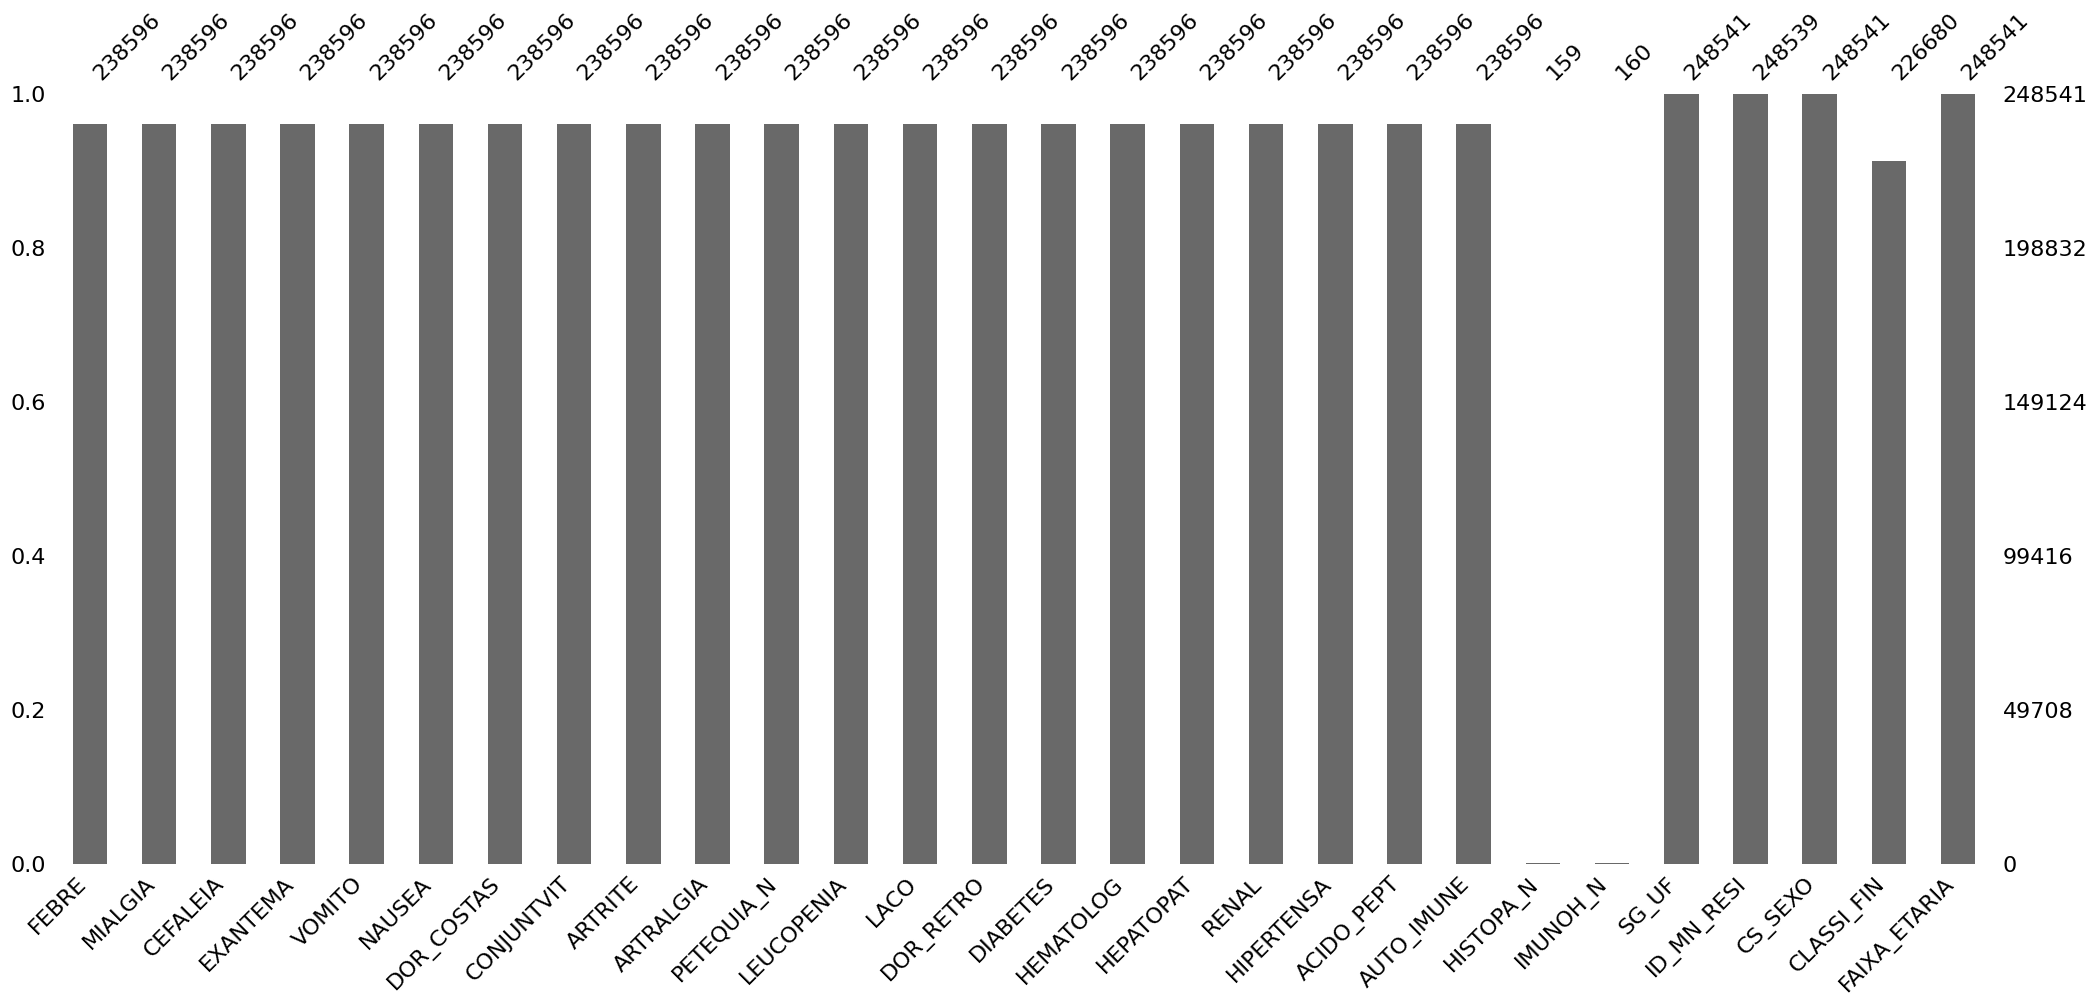

In [82]:
msno.bar(df)

#### Verificação completa do DataFrame

In [83]:
print("=== VERIFICAÇÃO DO DATAFRAME ===")
print(f"df.shape: {df.shape}")
print(f"Número de colunas (len(df.columns)): {len(df.columns)}")

# Se o número de colunas não der 24, clica em Run All. Provavelmente o notebook estava em um 
# estado inconsistente antes (células executadas em ordem diferente ou DataFrame modificado)

=== VERIFICAÇÃO DO DATAFRAME ===
df.shape: (248541, 28)
Número de colunas (len(df.columns)): 28


In [84]:
# Remover colunas com mais de 99% de valores nulos
null_ratio = df.isnull().mean()
null_threshold = 0.99

# Debug: mostrar proporção de nulos das duas colunas de exames
print("\nVerificação das colunas de exames:")
print(f"HISTOPA_N: {null_ratio['HISTOPA_N']:.4f} ({null_ratio['HISTOPA_N']*100:.2f}% nulos)")
print(f"IMUNOH_N: {null_ratio['IMUNOH_N']:.4f} ({null_ratio['IMUNOH_N']*100:.2f}% nulos)")

# Identificar colunas que serão removidas
colunas_para_remover = null_ratio[null_ratio >= null_threshold].index.tolist()
print(f"\nColunas que serão removidas (>= {null_threshold*100}% nulos): {colunas_para_remover}")
print(f"Total de colunas a remover: {len(colunas_para_remover)}")

# Remover colunas com mais de 70% de valores nulos
df = df.loc[:, df.isnull().mean() < null_threshold]

print(f"\nApós remoção por nulos: {df.shape}")


Verificação das colunas de exames:
HISTOPA_N: 0.9994 (99.94% nulos)
IMUNOH_N: 0.9994 (99.94% nulos)

Colunas que serão removidas (>= 99.0% nulos): ['HISTOPA_N', 'IMUNOH_N']
Total de colunas a remover: 2

Após remoção por nulos: (248541, 26)


<Axes: >

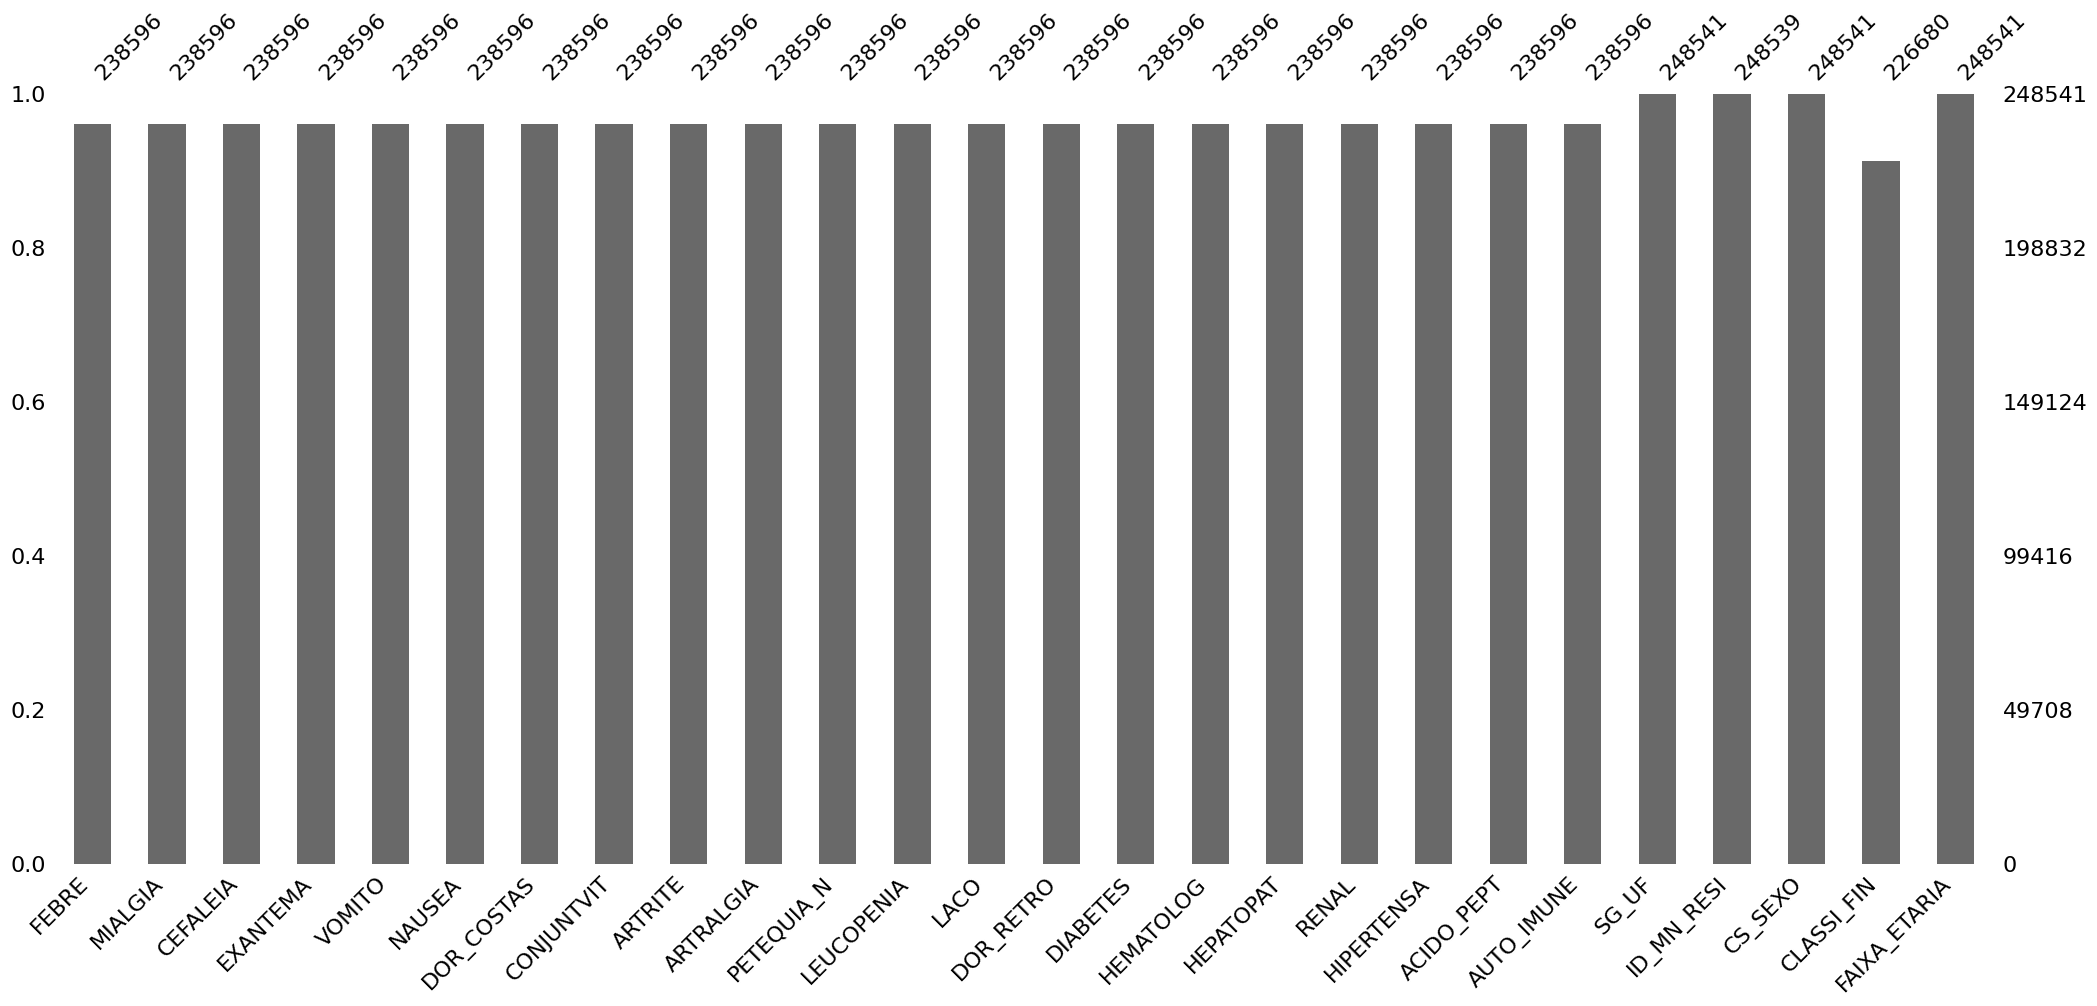

In [85]:
msno.bar(df)

#### Removendo linhas que possuem a "CLASSI_FIN" null, essa é a nossa váriavel alvo

In [86]:
linhas_com_nulo = df["CLASSI_FIN"].isnull().sum()
print(f"Excluir {linhas_com_nulo} linhas nulas em CLASSI_FIN")

# Removendo as linhas nulas
df = df[df["CLASSI_FIN"].notnull()]
linhas_depois = df.shape[0]

Excluir 21861 linhas nulas em CLASSI_FIN


In [87]:
# Colunas com valores nulos

df.isnull().sum()

FEBRE           5844
MIALGIA         5844
CEFALEIA        5844
EXANTEMA        5844
VOMITO          5844
NAUSEA          5844
DOR_COSTAS      5844
CONJUNTVIT      5844
ARTRITE         5844
ARTRALGIA       5844
PETEQUIA_N      5844
LEUCOPENIA      5844
LACO            5844
DOR_RETRO       5844
DIABETES        5844
HEMATOLOG       5844
HEPATOPAT       5844
RENAL           5844
HIPERTENSA      5844
ACIDO_PEPT      5844
AUTO_IMUNE      5844
SG_UF              0
ID_MN_RESI         2
CS_SEXO            0
CLASSI_FIN         0
FAIXA_ETARIA       0
dtype: int64

In [88]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 226680 entries, 0 to 248539
Data columns (total 26 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   FEBRE         220836 non-null  float64
 1   MIALGIA       220836 non-null  float64
 2   CEFALEIA      220836 non-null  float64
 3   EXANTEMA      220836 non-null  float64
 4   VOMITO        220836 non-null  float64
 5   NAUSEA        220836 non-null  float64
 6   DOR_COSTAS    220836 non-null  float64
 7   CONJUNTVIT    220836 non-null  float64
 8   ARTRITE       220836 non-null  float64
 9   ARTRALGIA     220836 non-null  float64
 10  PETEQUIA_N    220836 non-null  float64
 11  LEUCOPENIA    220836 non-null  float64
 12  LACO          220836 non-null  float64
 13  DOR_RETRO     220836 non-null  float64
 14  DIABETES      220836 non-null  float64
 15  HEMATOLOG     220836 non-null  float64
 16  HEPATOPAT     220836 non-null  float64
 17  RENAL         220836 non-null  float64
 18  HIPERTENS

In [89]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

# Ajustar e transformar o rótulo 'CS_SEXO'
df['CS_SEXO'] = label_encoder.fit_transform(df['CS_SEXO'])

df.head()

,FEBRE,MIALGIA,CEFALEIA,EXANTEMA,VOMITO,NAUSEA,DOR_COSTAS,CONJUNTVIT,ARTRITE,ARTRALGIA,PETEQUIA_N,LEUCOPENIA,LACO,DOR_RETRO,DIABETES,HEMATOLOG,HEPATOPAT,RENAL,HIPERTENSA,ACIDO_PEPT,AUTO_IMUNE,SG_UF,ID_MN_RESI,CS_SEXO,CLASSI_FIN,FAIXA_ETARIA
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,32,320060.00,0,5.00,2
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,32,320405.00,2,13.00,2
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,32,320130.00,2,5.00,2
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,32,320130.00,0,5.00,2
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,32,320130.00,0,5.00,1


In [90]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 226680 entries, 0 to 248539
Data columns (total 26 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   FEBRE         220836 non-null  float64
 1   MIALGIA       220836 non-null  float64
 2   CEFALEIA      220836 non-null  float64
 3   EXANTEMA      220836 non-null  float64
 4   VOMITO        220836 non-null  float64
 5   NAUSEA        220836 non-null  float64
 6   DOR_COSTAS    220836 non-null  float64
 7   CONJUNTVIT    220836 non-null  float64
 8   ARTRITE       220836 non-null  float64
 9   ARTRALGIA     220836 non-null  float64
 10  PETEQUIA_N    220836 non-null  float64
 11  LEUCOPENIA    220836 non-null  float64
 12  LACO          220836 non-null  float64
 13  DOR_RETRO     220836 non-null  float64
 14  DIABETES      220836 non-null  float64
 15  HEMATOLOG     220836 non-null  float64
 16  HEPATOPAT     220836 non-null  float64
 17  RENAL         220836 non-null  float64
 18  HIPERTENS

#### Análise e remoção de linhas com todos os valores nulos

In [91]:
from sklearn.impute import SimpleImputer
import numpy as np

np.random.seed(42)
# # Preenche os valores NaN com a mediana das colunas
imputer = SimpleImputer(missing_values= np.nan, strategy='median')
df = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)



df.info()

# Nury: Acho que as linhas poderiam ser removidas, pois o dataset é grande e a perda de algumas linhas não deve impactar muito a análise futura.
# Debora: Concordo

df_nulos = df.isnull()
colunas_analise = [col for col in df.columns if col != 'CLASSI_FIN']
print(f"1. Analisando {len(colunas_analise)} colunas (todas exceto CLASSI_FIN)\n")

# Quantas linhas têm nulos em TODAS as colunas (exceto CLASSI_FIN)
linhas_todos_nulos = df_nulos[colunas_analise].all(axis=1).sum()
print(f"\n2. Linhas com TODAS as colunas (exceto CLASSI_FIN) nulas: {linhas_todos_nulos:,}")

# Removendo linhas com todas as colunas (exceto CLASSI_FIN) nulas
print(f"\n3. Removendo {linhas_todos_nulos:,} linhas com todas as colunas nulas...")
print(f"   Shape antes: {df.shape}")
df = df[~df_nulos[colunas_analise].all(axis=1)]
print(f"   Shape depois: {df.shape}")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 226680 entries, 0 to 226679
Data columns (total 26 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   FEBRE         226680 non-null  float64
 1   MIALGIA       226680 non-null  float64
 2   CEFALEIA      226680 non-null  float64
 3   EXANTEMA      226680 non-null  float64
 4   VOMITO        226680 non-null  float64
 5   NAUSEA        226680 non-null  float64
 6   DOR_COSTAS    226680 non-null  float64
 7   CONJUNTVIT    226680 non-null  float64
 8   ARTRITE       226680 non-null  float64
 9   ARTRALGIA     226680 non-null  float64
 10  PETEQUIA_N    226680 non-null  float64
 11  LEUCOPENIA    226680 non-null  float64
 12  LACO          226680 non-null  float64
 13  DOR_RETRO     226680 non-null  float64
 14  DIABETES      226680 non-null  float64
 15  HEMATOLOG     226680 non-null  float64
 16  HEPATOPAT     226680 non-null  float64
 17  RENAL         226680 non-null  float64
 18  HIPE

<Axes: >

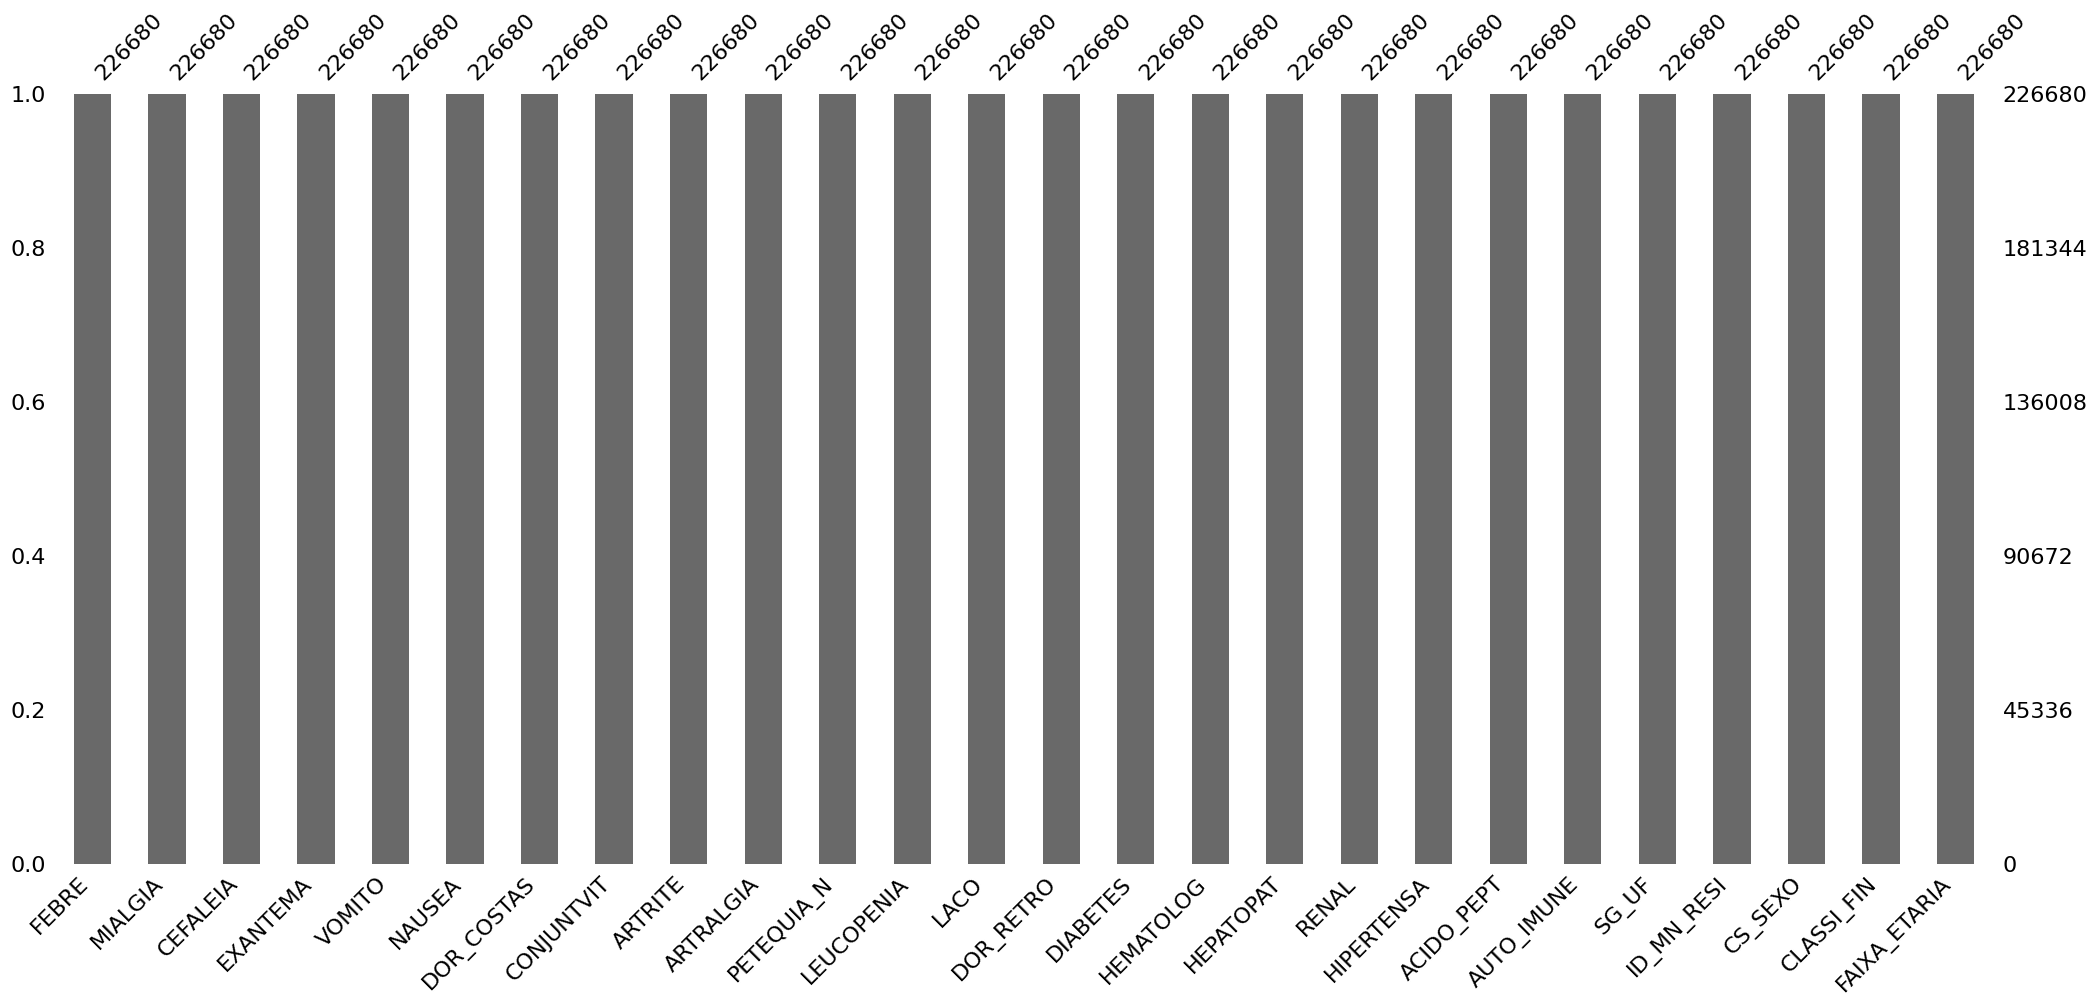

In [92]:
msno.bar(df)

### A coluna target está equilibrada? 

- 5 = Não tem chikungunya
- 13 = Tem chikungunya


Análise: A quantidade entre casos com e sem chickungunya está bem parecido

(array([1.96027991, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 1.78972009]),
 array([ 5.        ,  5.26666667,  5.53333333,  5.8       ,  6.06666667,
         6.33333333,  6.6       ,  6.86666667,  7.13333333,  7.4       ,
         7.66666667,  7.93333333,  8.2       ,  8.46666667,  8.73333333,
         9.        ,  9.26666667,  9.53333333,  9.8       , 10.06666667,
        10.33333333, 10.6       , 10.86666667, 11.13333333, 11.4       ,
        11.66666667, 11.93333333, 12.2       , 12.46666667, 12.73333333,
        13.        ]),
 <BarContainer object of 30 artists>)

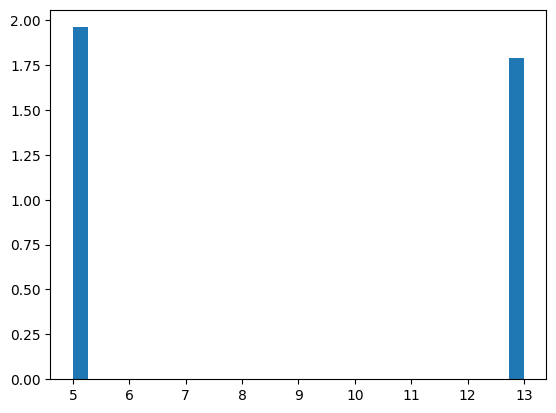

In [93]:
plt.hist(df['CLASSI_FIN'], density=True, bins=30) 

### Análise de correlação

#### Correlação entre colunas

Análise:
Para a classi_fin as colunas estao bem distribuidas sem nenhum detaque aparente. 
Tem algumas colunas que se relacionam entre si, como Vomito e Nausea, Dor nas costas e Artrite e Diabetes e Hipertensão

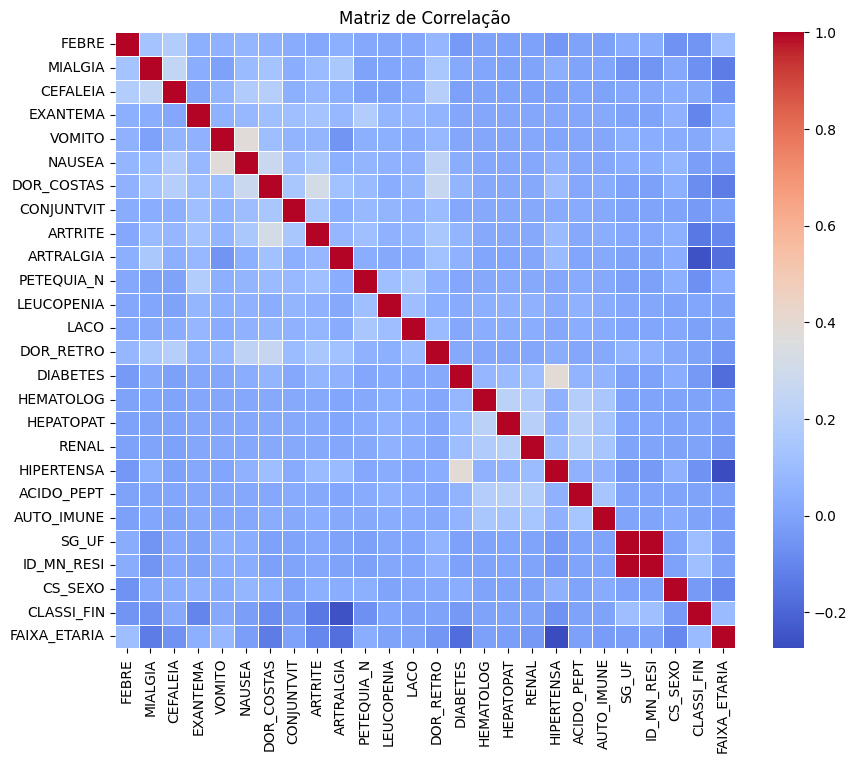

In [94]:
df_corr = df.corr()

plt.figure(figsize=(10, 8))

sns.heatmap(df_corr, cmap='coolwarm', annot=False, fmt=".2f", linewidths=.5)

plt.title('Matriz de Correlação')
plt.show()

In [95]:
df.corr()["CLASSI_FIN"].sort_values(ascending=False)

CLASSI_FIN      1.00
ID_MN_RESI      0.11
SG_UF           0.11
FAIXA_ETARIA    0.09
VOMITO          0.02
CEFALEIA        0.02
LEUCOPENIA      0.01
HEPATOPAT       0.00
RENAL          -0.00
HEMATOLOG      -0.00
DOR_RETRO      -0.00
ACIDO_PEPT     -0.00
AUTO_IMUNE     -0.00
LACO           -0.01
NAUSEA         -0.02
CONJUNTVIT     -0.03
CS_SEXO        -0.03
DIABETES       -0.04
FEBRE          -0.05
HIPERTENSA     -0.06
MIALGIA        -0.07
PETEQUIA_N     -0.07
DOR_COSTAS     -0.08
EXANTEMA       -0.10
ARTRITE        -0.14
ARTRALGIA      -0.26
Name: CLASSI_FIN, dtype: float64

In [96]:
# Separar linhas campo classi_fin valor 13 e 5

# Criar um dataframe que contém apenas as duas classes de interesse
df_analise = df[df["CLASSI_FIN"].isin([5.0, 13.0])]

# Agora a correlação funcionará pois existem valores diferentes (5 e 13)
correlacao = df_analise.corr()["CLASSI_FIN"].sort_values(ascending=False)
print(correlacao)

correlacao.value_counts()



CLASSI_FIN      1.00
ID_MN_RESI      0.11
SG_UF           0.11
FAIXA_ETARIA    0.09
VOMITO          0.02
CEFALEIA        0.02
LEUCOPENIA      0.01
HEPATOPAT       0.00
RENAL          -0.00
HEMATOLOG      -0.00
DOR_RETRO      -0.00
ACIDO_PEPT     -0.00
AUTO_IMUNE     -0.00
LACO           -0.01
NAUSEA         -0.02
CONJUNTVIT     -0.03
CS_SEXO        -0.03
DIABETES       -0.04
FEBRE          -0.05
HIPERTENSA     -0.06
MIALGIA        -0.07
PETEQUIA_N     -0.07
DOR_COSTAS     -0.08
EXANTEMA       -0.10
ARTRITE        -0.14
ARTRALGIA      -0.26
Name: CLASSI_FIN, dtype: float64


CLASSI_FIN
1.00     1
0.11     1
0.11     1
0.09     1
0.02     1
0.02     1
0.01     1
0.00     1
-0.00    1
-0.00    1
-0.00    1
-0.00    1
-0.00    1
-0.01    1
-0.02    1
-0.03    1
-0.03    1
-0.04    1
-0.05    1
-0.06    1
-0.07    1
-0.07    1
-0.08    1
-0.10    1
-0.14    1
-0.26    1
Name: count, dtype: int64

In [97]:
df['TARGET'] = df['CLASSI_FIN'].map({13.0: 1, 5.0: 0})
df = df.dropna(subset=['TARGET'])

In [98]:
# Como não há uma correlação forte entre as variáveis, será utilizado o modelo de Árvore de Decisão que não depende de correlações lineares entre as variáveis.

In [99]:

# Separando as variáveis preditoras (X) da variável alvo (y)

df_regressao = df.copy()
X = df_regressao.drop(columns=['TARGET', 'CLASSI_FIN']) # Variáveis características
y = df_regressao['TARGET'] # O que eu quero prever. (Target)

## Treino modelo - LinearRegression

In [100]:
# Separando as bases em treino e teste
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(len(X_train), "feature de treinamento +", len(X_test), "teste")

181344 feature de treinamento + 45336 teste


In [101]:
# Criando e treinando o modelo de regressão linear
from sklearn.linear_model import LinearRegression

regressaoLinear = LinearRegression()
regressaoLinear.fit(X_train, y_train)

# Fazendo previsões no conjunto de teste
previsoes = regressaoLinear.predict(X_test)

In [102]:
# Avaliando o desempenho do modelo

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

rmse = mean_squared_error(y_test, previsoes)
mae = mean_absolute_error(y_test, previsoes)
r2 = r2_score(y_test, previsoes)

print(f'RMSE: {rmse}')
print(f'MAE: {mae}')
print(f'R²: {r2}')

RMSE: 0.21659492312943954
MAE: 0.4312493169904995
R²: 0.13209914314865756


## Treino modelo - RandomForestRegressor

In [103]:
from sklearn.ensemble import RandomForestRegressor

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

randomForest = RandomForestRegressor()
randomForest.fit(X_train, y_train)

previsoes = randomForest.predict(X_test)

# Avaliando o desempenho do modelo

rmse = mean_squared_error(y_test, previsoes)
mae = mean_absolute_error(y_test, previsoes)
r2 = r2_score(y_test, previsoes)

print(f'RMSE: {rmse}')
print(f'MAE: {mae}')
print(f'R²: {r2}')

RMSE: 0.14786941991336186
MAE: 0.25769195781734805
R²: 0.4072962126319103


In [104]:
X_train.shape

(181344, 25)

In [105]:
df.isnull().sum()

FEBRE           0
MIALGIA         0
CEFALEIA        0
EXANTEMA        0
VOMITO          0
NAUSEA          0
DOR_COSTAS      0
CONJUNTVIT      0
ARTRITE         0
ARTRALGIA       0
PETEQUIA_N      0
LEUCOPENIA      0
LACO            0
DOR_RETRO       0
DIABETES        0
HEMATOLOG       0
HEPATOPAT       0
RENAL           0
HIPERTENSA      0
ACIDO_PEPT      0
AUTO_IMUNE      0
SG_UF           0
ID_MN_RESI      0
CS_SEXO         0
CLASSI_FIN      0
FAIXA_ETARIA    0
TARGET          0
dtype: int64

## Treino modelo - RandomForestClassifier

In [106]:
# Ajuste para usar algoritmo de classificação

df_classificacao = df.copy()

X_classif = df_classificacao.drop(columns=['TARGET', 'CLASSI_FIN']).astype(int)

# O y deve ser o TARGET original (0 e 1), sem o log1p
y_classif = df_classificacao['TARGET'].astype(int)

print("Tipos de dados em X:\n", X_classif.dtypes.value_counts())
print("\nTipo de dado em y:", y_classif.dtype)

Tipos de dados em X:
 int64    25
Name: count, dtype: int64

Tipo de dado em y: int64


In [107]:
from sklearn.ensemble import RandomForestClassifier

X_train_classif, X_test_classif, y_train_classif, y_test_classif = train_test_split(
    X_classif, y_classif, test_size=0.2, random_state=42, stratify=y_classif
)


randomForestClassifier = RandomForestClassifier()
randomForestClassifier.fit(X_train_classif, y_train_classif)

previsoes = randomForestClassifier.predict(X_test_classif)


In [108]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score

# Avaliando as métricas de Classificação
acuracia = accuracy_score(y_test_classif, previsoes)
f1 = f1_score(y_test_classif, previsoes)

print(f'Acurácia (Total de acertos): {acuracia:.4f}')
print(f'F1-Score (Equilíbrio entre precisão e busca): {f1:.4f}')

print("\n--- Matriz de Confusão ---")
# Mostra exatamente onde o modelo acertou e onde ele confundiu os diagnósticos
print(confusion_matrix(y_test, previsoes))

print("\n--- Relatório de Classificação Completo ---")
print(classification_report(y_test, previsoes))

Acurácia (Total de acertos): 0.7704
F1-Score (Equilíbrio entre precisão e busca): 0.7563

--- Matriz de Confusão ---
[[18780  4919]
 [ 5488 16149]]

--- Relatório de Classificação Completo ---
              precision    recall  f1-score   support

           0       0.77      0.79      0.78     23699
           1       0.77      0.75      0.76     21637

    accuracy                           0.77     45336
   macro avg       0.77      0.77      0.77     45336
weighted avg       0.77      0.77      0.77     45336



## Ajustando os Hiperparâmetros do RandomForestClassifier

In [109]:
randomForestClassifier = RandomForestClassifier(
    n_estimators=500,       # Mais árvores para estabilidade
    max_depth=15,           # Limita a profundidade para não decorar (overfit)
    min_samples_leaf=10,    # Garante que cada "folha" tenha dados suficientes
    class_weight='balanced',# Dá mais peso para a classe com menos dados
    random_state=42
)

randomForestClassifier.fit(X_train_classif, y_train_classif)

previsoes_hiperparametros = randomForestClassifier.predict(X_test_classif)

In [110]:
# Avaliando as métricas de Classificação
acuracia = accuracy_score(y_test_classif, previsoes_hiperparametros)
f1 = f1_score(y_test_classif, previsoes_hiperparametros)

print(f'Acurácia (Total de acertos): {acuracia:.4f}')
print(f'F1-Score (Equilíbrio entre precisão e busca): {f1:.4f}')

print("\n--- Matriz de Confusão ---")
# Mostra exatamente onde o modelo acertou e onde ele confundiu os diagnósticos
print(confusion_matrix(y_test_classif, previsoes_hiperparametros))

print("\n--- Relatório de Classificação Completo ---")
print(classification_report(y_test_classif, previsoes_hiperparametros))

Acurácia (Total de acertos): 0.7733
F1-Score (Equilíbrio entre precisão e busca): 0.7567

--- Matriz de Confusão ---
[[19073  4626]
 [ 5653 15984]]

--- Relatório de Classificação Completo ---
              precision    recall  f1-score   support

           0       0.77      0.80      0.79     23699
           1       0.78      0.74      0.76     21637

    accuracy                           0.77     45336
   macro avg       0.77      0.77      0.77     45336
weighted avg       0.77      0.77      0.77     45336



## Treino modelo - KNeighborsClassifier

In [111]:
df_kneighbors = df.copy()

X_kneighbors = df_kneighbors.drop(columns=['TARGET', 'CLASSI_FIN']).astype(int)

y_kneighbors= df_kneighbors['TARGET'].astype(int)

print("Tipos de dados em X:\n", X_kneighbors.dtypes.value_counts())
print("\nTipo de dado em y:", y_kneighbors.dtype)

Tipos de dados em X:
 int64    25
Name: count, dtype: int64

Tipo de dado em y: int64


In [112]:
from sklearn.neighbors import KNeighborsClassifier

modelo_kneighbors = KNeighborsClassifier(n_neighbors=3)

X_train_kneighbors, X_test_kneighbors, y_train_kneighbors, y_test_kneighbors = train_test_split(
    X_kneighbors, y_kneighbors, test_size=0.2, random_state=42, stratify=y_kneighbors
)

modelo_kneighbors.fit(X_train_kneighbors, y_train_kneighbors)

previsoes_kneighbors = modelo_kneighbors.predict(X_test_kneighbors)

In [113]:
# Avaliando as métricas de Classificação
acuracia = accuracy_score(y_test_kneighbors, previsoes_kneighbors)
f1 = f1_score(y_test_kneighbors, previsoes_kneighbors)

print(f'Acurácia (Total de acertos): {acuracia:.4f}')
print(f'F1-Score (Equilíbrio entre precisão e busca): {f1:.4f}')

print("\n--- Matriz de Confusão ---")
# Mostra exatamente onde o modelo acertou e onde ele confundiu os diagnósticos
print(confusion_matrix(y_test_kneighbors, previsoes_kneighbors))

print("\n--- Relatório de Classificação Completo ---")
print(classification_report(y_test_kneighbors, previsoes_kneighbors))

Acurácia (Total de acertos): 0.7830
F1-Score (Equilíbrio entre precisão e busca): 0.7713

--- Matriz de Confusão ---
[[18917  4782]
 [ 5054 16583]]

--- Relatório de Classificação Completo ---
              precision    recall  f1-score   support

           0       0.79      0.80      0.79     23699
           1       0.78      0.77      0.77     21637

    accuracy                           0.78     45336
   macro avg       0.78      0.78      0.78     45336
weighted avg       0.78      0.78      0.78     45336



## Treino modelo - XGBoost

In [114]:
df_xgboost = df.copy()

X_xgboost = df_xgboost.drop(columns=['TARGET', 'CLASSI_FIN']).astype(int)

y_xgboost= df_xgboost['TARGET'].astype(int)

print("Tipos de dados em X:\n", X_xgboost.dtypes.value_counts())
print("\nTipo de dado em y:", y_xgboost.dtype)

Tipos de dados em X:
 int64    25
Name: count, dtype: int64

Tipo de dado em y: int64


In [115]:
from xgboost import XGBClassifier

# Instale se necessário: !pip install xgboost
modelo_xgb = XGBClassifier(
    n_estimators=200, 
    learning_rate=0.05, 
    max_depth=6, 
    random_state=42
)

X_train_xgboost, X_test_xgboost, y_train_xgboost, y_test_xgboost = train_test_split(
    X_xgboost, y_xgboost, test_size=0.2, random_state=42, stratify=y_xgboost
)

modelo_xgb.fit(X_train_xgboost, y_train_xgboost)
previsoes_xgboost = modelo_xgb.predict(X_test_xgboost)

In [116]:
# Avaliando as métricas de Classificação
acuracia = accuracy_score(y_test_xgboost, previsoes_xgboost)
f1 = f1_score(y_test_xgboost, previsoes_xgboost)

print(f'Acurácia (Total de acertos): {acuracia:.4f}')
print(f'F1-Score (Equilíbrio entre precisão e busca): {f1:.4f}')

print("\n--- Matriz de Confusão ---")
# Mostra exatamente onde o modelo acertou e onde ele confundiu os diagnósticos
print(confusion_matrix(y_test_xgboost, previsoes_xgboost))

print("\n--- Relatório de Classificação Completo ---")
print(classification_report(y_test_xgboost, previsoes_xgboost))

Acurácia (Total de acertos): 0.7868
F1-Score (Equilíbrio entre precisão e busca): 0.7662

--- Matriz de Confusão ---
[[19834  3865]
 [ 5799 15838]]

--- Relatório de Classificação Completo ---
              precision    recall  f1-score   support

           0       0.77      0.84      0.80     23699
           1       0.80      0.73      0.77     21637

    accuracy                           0.79     45336
   macro avg       0.79      0.78      0.79     45336
weighted avg       0.79      0.79      0.79     45336



## Treino modelo - LightGBM

In [117]:
df_lightgbm = df.copy()

X_lightgbm = df_lightgbm.drop(columns=['TARGET', 'CLASSI_FIN']).astype(int)

y_lightgbm= df_lightgbm['TARGET'].astype(int)

print("Tipos de dados em X:\n", X_lightgbm.dtypes.value_counts())
print("\nTipo de dado em y:", y_lightgbm.dtype)

Tipos de dados em X:
 int64    25
Name: count, dtype: int64

Tipo de dado em y: int64


In [134]:
import lightgbm as lgb

model_lgb = lgb.LGBMClassifier(
    objective= "binary",           # Classificação binária
    boosting_type= "gbdt",         # Gradient Boosting clássico
    learning_rate= 0.05,           # Passo pequeno, evita overfitting
    n_estimators= 500,             # Número de árvores, suficiente pra compensar learning_rate baixo
    max_depth= 5,                   # Profundidade das árvores (evita overfitting, mas permite padrões complexos)
    num_leaves= 31,                 # Número máximo de folhas por árvore
    min_data_in_leaf= 20,           # Mínimo de amostras por folha (não bloqueia splits)
    min_gain_to_split= 0,           # Ganho mínimo para aceitar split (0 = qualquer split que ajude)
    feature_fraction= 0.8,          # Amostra de features em cada árvore (reduz overfitting)
    bagging_fraction= 0.8,          # Amostra de dados em cada árvore
    bagging_freq= 1,                # Frequência de bagging
    verbose= -1,                     # Não mostra logs desnecessários
    random_state=42)

X_train_lightgbm, X_test_lightgbm, y_train_lightgbm, y_test_lightgbm = train_test_split(
    X_lightgbm, y_lightgbm, test_size=0.2, random_state=42, stratify=y_lightgbm
)

model_lgb.fit(X_train_lightgbm,y_train_lightgbm,eval_set=[(X_test_lightgbm, y_test_lightgbm),(X_train_lightgbm, y_train_lightgbm)],eval_metric='logloss')

model_lgb.fit(X_train_lightgbm, y_train_lightgbm)
previsoes_lightgbm = model_lgb.predict(X_test_lightgbm)

In [135]:
# Avaliando as métricas de Classificação
acuracia = accuracy_score(y_test_lightgbm, previsoes_lightgbm)
f1 = f1_score(y_test_lightgbm, previsoes_lightgbm)

print(f'Acurácia (Total de acertos): {acuracia:.4f}')
print(f'F1-Score (Equilíbrio entre precisão e busca): {f1:.4f}')

print("\n--- Matriz de Confusão ---")
# Mostra exatamente onde o modelo acertou e onde ele confundiu os diagnósticos
print(confusion_matrix(y_test_lightgbm, previsoes_lightgbm))

print("\n--- Relatório de Classificação Completo ---")
print(classification_report(y_test_lightgbm, previsoes_lightgbm))

Acurácia (Total de acertos): 0.7955
F1-Score (Equilíbrio entre precisão e busca): 0.7783

--- Matriz de Confusão ---
[[19787  3912]
 [ 5359 16278]]

--- Relatório de Classificação Completo ---
              precision    recall  f1-score   support

           0       0.79      0.83      0.81     23699
           1       0.81      0.75      0.78     21637

    accuracy                           0.80     45336
   macro avg       0.80      0.79      0.79     45336
weighted avg       0.80      0.80      0.79     45336



## Comparativo de modelos

In [ ]:
## Criar uma tabela de valores dos desempenhos dos modelos testados